In [1]:
import tensorflow as tf
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import sobol
import nbimporter
from PINN_Solver_Classes import *
from PDE_Classes import *
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
# from keras import callbacks
# import time
# import itertools as product

# Set data type
DTYPE = 'float64'
tf.keras.backend.set_floatx(DTYPE)

In [32]:
N_b = 1 # number of points at each boundary
N_r = 2**15 # number of internal collocation points

# Declare bounds of each subdomain
x_b = [0, 1]

# Lower bound of domain
x0 = tf.constant(x_b[0], dtype=DTYPE)
# Upper bound of domain 
x1 = tf.constant(x_b[1], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Generate boundary points
X_b = tuple( tf.constant(np.repeat([[i]], N_b, axis=0), dtype=DTYPE) for i in x_b )

# Declare PDE parameters
nu = 0.05
beta = 1

# Generate internal points wiht gaussian distribution about the shock
# mu = (nu/beta)*np.log( ( nu/beta )*( np.exp(beta/nu) - 1 ) )
# sigma = (x1 - x0)/2
# N = stats.truncnorm((x0 - mu) / sigma, (x1 - mu) / sigma, loc=mu, scale=sigma)

# Generate uniformly distributed internal points for the whole domain
points = sobol.sample(dimension=1, n_points=N_r)
xwidth = x1 - x0
x = xwidth*points + x0

# Store internal points as tensor object
X_r = tf.constant(x, shape=(N_r, 1), dtype=DTYPE)

# fig, ax = plt.subplots(1,1)
# ax.hist(N.rvs(N_r))
# plt.show()

In [33]:
# Declare pde as a class for dynamic inheritance
pde = PDE_1D_Steady_AdvecDiff

# Then declare an instance of the PDE class to use in the Driver
pde1 = pde(nu=nu, beta=beta)

# Generate data for boundary conditions
U_b = tuple( pde1.f_b(x) for x in X_b  )

# Build neural network
model = PINN_Architecture(x0, x1)
model.build(input_shape=(None, X_r.shape[1]))

# Initialize solver
alpha = 0.3
pss = PINN_Solver_Steady(model, X_r, X_b, U_b, alpha, pde, nu=nu, beta=beta)

# Define learning schedule and choose optimizer (Adam)
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2**8,2**9],[1e-3,5e-4,1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Declare hyperparameters
numEpochs = 512
batch_size = 32

# Solve PINN
pss.solve(optimizer, batch_size, numEpochs)

Epoch     1: loss = 2.94800624e-01
Epoch    33: loss = 2.91843748e-01
Epoch    65: loss = 2.91683290e-01
Epoch    97: loss = 2.91759145e-01
Epoch   129: loss = 2.91718525e-01


KeyboardInterrupt: 

Text(0, 0.5, 'u(x)')

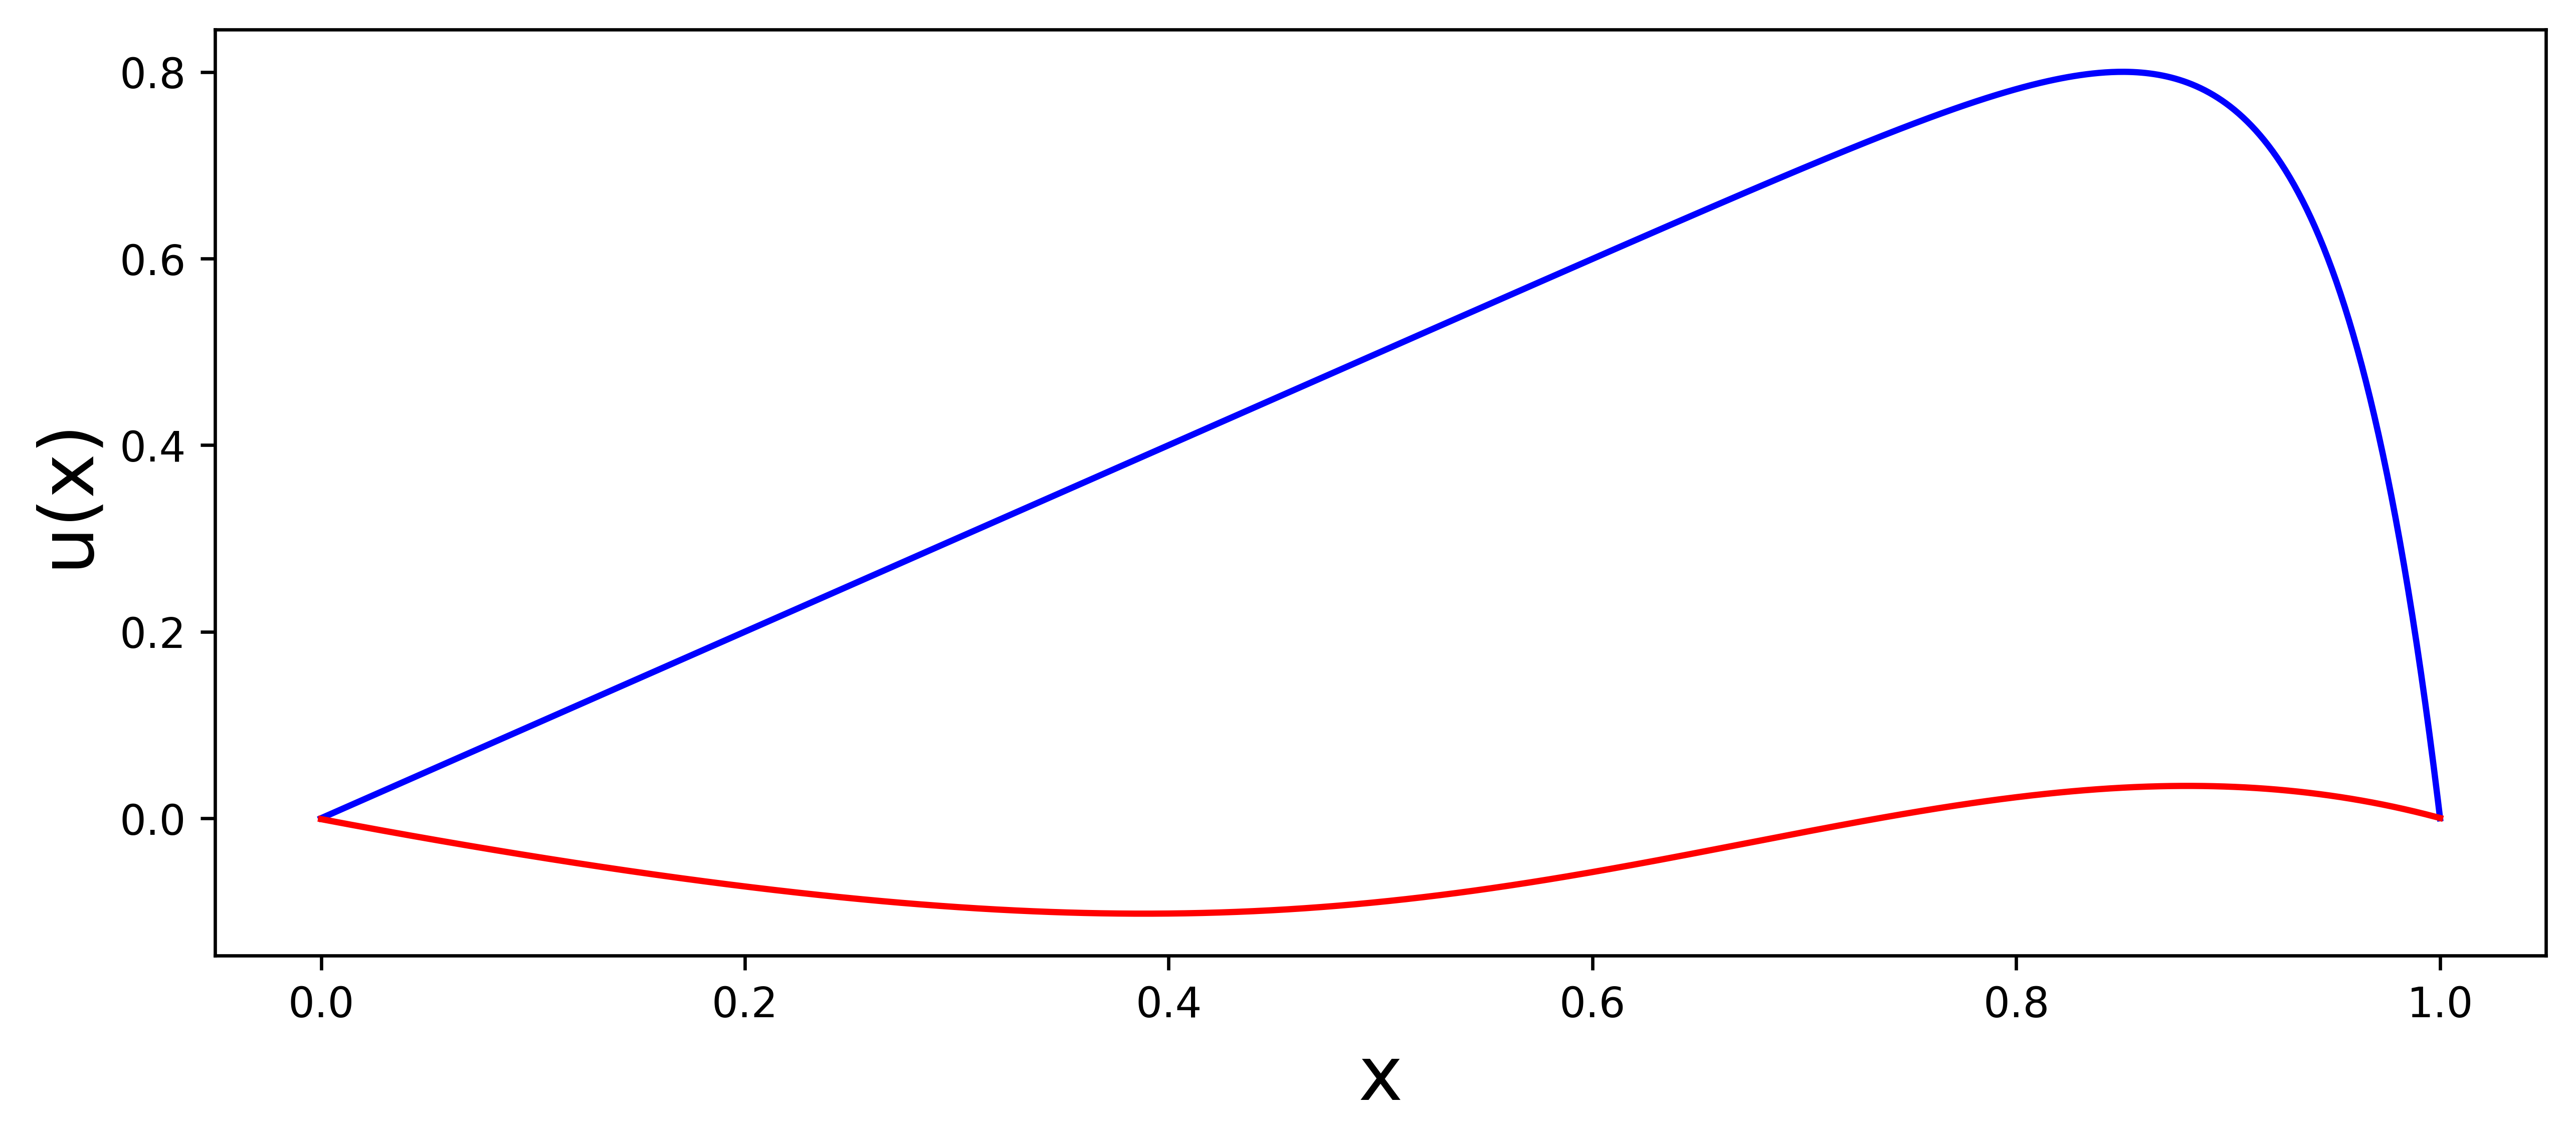

In [25]:
x = tf.constant(np.linspace(0, 1, num=1001), shape=(1001, 1), dtype=DTYPE)

u_true = pde1.f(x)
u_pred = model(x)

fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=600)

ax.plot(x, u_true, 'b-', x, u_pred, 'r-')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('u(x)', fontsize=18)